## Building a CNN to classify images.


### รูปภาพที่ให้มามี 4 คลาส โดยมีหมายเลขคลาสดังนี้:
<ol start="0">
<li> frog
<li> cat
<li> dog
<li> horse
</ol>

In [51]:
import time, datetime
import requests, pickle
import numpy as np
from tensorflow import keras
from IPython import display

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [52]:
import random, os, tensorflow as tf

def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # to Disable GPU training

In [53]:
print('Default GPU Device:', tf.test.gpu_device_name() or 'None')

Default GPU Device: /device:GPU:0


In [54]:
class_names = ['frog', 'cat', 'dog', 'horse']

# (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(open('364_midterm_data.pkl', "rb"))

url = "https://drive.google.com/uc?id=1v6wfLWvOzq2Aaw7MuhnkZd1VRCgLTh4b"
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.loads(requests.get(url).content)

### ดูรูปภาพในชุดข้อมูล

In [55]:
def show_images(X, y, class_names, n_rows=3, n_cols=8, figsize=(9, 4)):
    fig = plt.figure(figsize=figsize)
    for i in range(0, n_rows):
        for j in range(0, n_cols):
            idx = i*n_cols + j
            image = X[idx]
            label = class_names[y[idx][0]]
            ax = plt.subplot(n_rows, n_cols, idx+1)
            plt.imshow(image)
            plt.text(16, 36, str(y[idx]) + ' - ' + label, ha='center')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

[0] frog


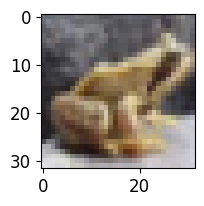

In [56]:
print(y_test[1], class_names[y_test[1][0]])
plt.figure(figsize=(2, 2))
plt.imshow(X_test[1])

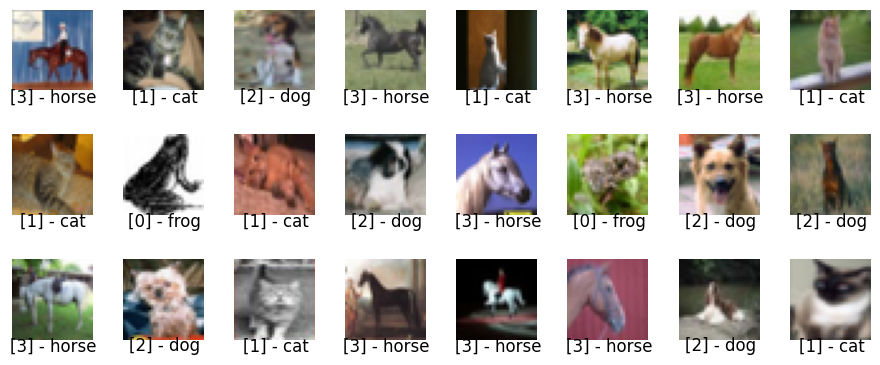

In [57]:
show_images(X_train, y_train, class_names, 3, 8)

### Normalize images and One-Hot Encode labels

In [58]:
n_classes = len(class_names)

y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [59]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

<style> h3 { margin-top: 0.5em !important; margin-bottom: 0.0em; }
        h4 { margin-top: 0.1em !important; margin-bottom: 0.1em; }
        h5 { margin-top: 0.0em; margin-bottom: 0.2em; } </style>

# <span style="color:blue">โจทย์คำถาม</span>
* ### เพื่อป้องกันผลกระทบจาก randomness ให้นิสิตใช้ค่า seed เป็น 12345 ในทุกกรณีที่เกี่ยวข้องกับการสุ่ม และให้เรียกใช้ฟังก์ชัน set_seed(12345) ทุกครั้งก่อนที่จะสร้างโมเดล
* ### ให้สร้างโมเดลด้วย CNN เพื่อให้ได้ accuracy ที่ดีที่สุด และห้ามใช้ Early Stopping หรือใช้ Best Weights ในการเทรนโมเดล โดยให้เทรนโมเดลเต็มจำนวน epoch ที่นิสิตกำหนด โดยค่า epoch ต้องไม่น้อยกว่า 50 และต้องหารด้วย 20 ลงตัว
  * #### (10 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.65
  * #### (15 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.70
  * #### (20 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.73
  * #### (25 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.75
  * #### (30 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.80
  * #### (35 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.83
  * #### (40 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.85
  * #### (50 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.90  
* ### (25 คะแนน) ให้แสดงกราฟ Loss และ Accuracy ของโมเดลที่เกิดจากการเทรนโมเดล และหลังจากโมเดลถูกเทรนแล้วเสร็จ ให้แสดงค่า Accuracy ที่วัดได้จากชุดข้อมูล train, validation และ test
* ### (25 คะแนน) ให้แสดง Confusion Matrix ผลการทำนายที่ได้จากโมเดลด้วยข้อมูลเทส
  ##### บอกใบ้ จากโค้ดข้างล่าง ค่าข้อมูลแต่ละตัวใน y_pred (ที่ได้จาก model.predict(...)) และ y_test จะมี 4 จำนวน (ตามจำนวนคลาส) โดยใน y_pred จะเก็บค่าความน่าจะเป็นที่อินพุต X_test จะเป็นแต่ละคลาส เช่น [0.6, 0.05, 0.15, 0.2] ซึ่งหมายถึง ความน่าจะเป็นที่อินพุตจะเป็นคลาส 0 มีค่าเป็น 0.6 และในลักษณะเดียวกัน y_test จะเก็บค่าผลเฉลยซึ่งอยู่ในรูป One-Hot Encoding เช่น [0, 0, 0, 1] ซึ่งหมายถึง ผลเฉลยของอินพุตเป็นคลาส 3 เป็นต้น เราใช้ np.argmax(...) เพื่อแปลงค่าที่อยู่ในรูปเวกเตอร์ให้กลายเป็นค่าสเกลาร์ เพื่อความสะดวกในการเปรียบเทียบระหว่างผลทำนายกับผลเฉลย
    ```python
    y_pred = model.predict(X_test, verbose=0)
    y_test_1d = np.argmax(y_test, axis=1
    y_pred_1d = np.argmax(y_pred, axis=1)
    ```
  ##### ในโมดูล sklearn ภายใต้ metrics มีฟังก์ชัน confusion_matrix(...) ที่ใช้คำนวณ Confusion Matrix<br>
* ### (25 คะแนน) ให้คำนวณค่า Recall ของแต่ละคลาสด้วยข้อมูลเทส โดยให้เขียนตอบในรูปนิพจน์ตามตัวอย่างด้านล่าง ซึ่งค่า Recall บ่งบอกถึงความสามารถของโมเดลในการทำนายคลาสที่สนใจได้อย่างถูกต้อง โดยโมเดลที่มีค่า Recall สูงบ่งบอกถึงโมเดลสามารถทำนายคลาสที่สนใจได้ถูกต้องเป็นจำนวนมาก ค่า Recall คำนวณได้จากสูตรข้างล่างนี้ <br><br> $$ Recall = {TruePositives \over TruePositives + FalseNegatives} $$
### จากตัวอย่างในตาราง Confusion Matrix ด้านล่างนี้ ค่า Recall ของคลาส Apple คำนวณได้จาก 7 / (7 + 1 + 3) = 0.6364 ส่วนของคลาส Orange คำนวณได้จาก 2 / (2 + 8 + 2) = 0.1667 และของคลาส Mango คำนวณได้จาก 1 / (1 + 9 + 3) = 0.0769

 <center><img src="https://drive.google.com/thumbnail?id=1v8N__pdOnfAV-JwBR4rfKJdTSqOSeAv4&sz=w500"></center>

* ### (โบนัส 20 คะแนน) จงเปรียบเทียบและอธิบายค่า Recall ที่คำนวณได้จากทั้ง 4 คลาส และให้แสดงภาพจำนวน 5 ภาพที่มาจากคลาสที่มีค่า Recall สูงสุดแต่โมเดลทำนายผิด โดยให้แสดงค่าคลาสของแต่ละภาพที่โมเดลทำนายออกมาด้วย

In [60]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [61]:
print(1e-3)

0.001


In [62]:
seed = 12345
set_seed(seed)

batch_size = 32
model = Sequential([
    Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(n_classes, activation='softmax'),
])


model.summary()
# 1e-3
model.compile(optimizer=SGD(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 7200)              0         
                                                                 
 dense_10 (Dense)            (None, 16)                115216    
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 116180 (453.83 KB)
Trainable params: 116180 (453.83 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [63]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=60,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/60
600/600 [==============================] - 3s 4ms/step - loss: 1.3524 - accuracy: 0.3386 - val_loss: 1.3273 - val_accuracy: 0.3642
Epoch 2/60
600/600 [==============================] - 2s 4ms/step - loss: 1.3064 - accuracy: 0.4158 - val_loss: 1.2930 - val_accuracy: 0.4008
Epoch 3/60
600/600 [==============================] - 2s 3ms/step - loss: 1.2670 - accuracy: 0.4523 - val_loss: 1.2494 - val_accuracy: 0.4642
Epoch 4/60
600/600 [==============================] - 2s 3ms/step - loss: 1.2298 - accuracy: 0.4714 - val_loss: 1.2180 - val_accuracy: 0.4783
Epoch 5/60
600/600 [==============================] - 2s 4ms/step - loss: 1.1994 - accuracy: 0.4887 - val_loss: 1.1886 - val_accuracy: 0.4875
Epoch 6/60
600/600 [==============================] - 2s 4ms/step - loss: 1.1747 - accuracy: 0.5034 - val_loss: 1.1773 - val_accuracy: 0.4896
Epoch 7/60
600/600 [==============================] - 3s 5ms/step - loss: 1.1550 - accuracy: 0.5081 - val_loss: 1.1496 - val_accuracy: 0.5092
Epoch 

In [64]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(X_train, y_train, verbose=0)))
print('Validation Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(X_val, y_val, verbose=0)))

Train Loss: 0.833250, Accuracy: 0.661146
Validation Loss: 0.868935, Accuracy: 0.642917


In [65]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

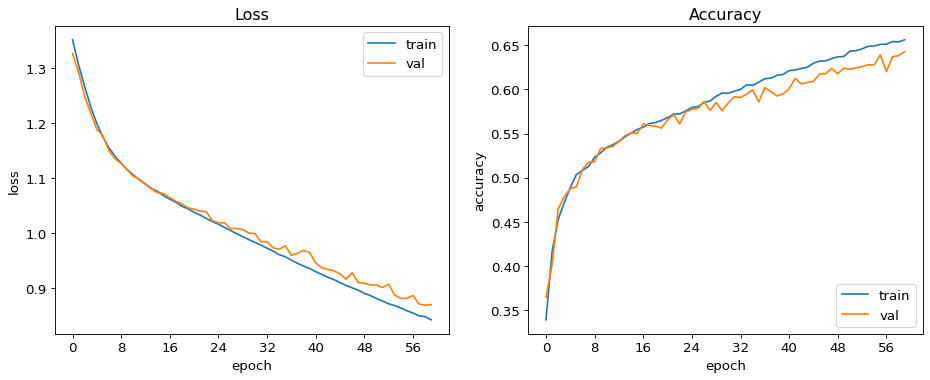

In [66]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [67]:
y_pred = model.predict(X_test, verbose=0)
y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

[[447  63  30  22]
 [ 80 279 136  37]
 [ 43 173 339  70]
 [ 30  85  95 471]]


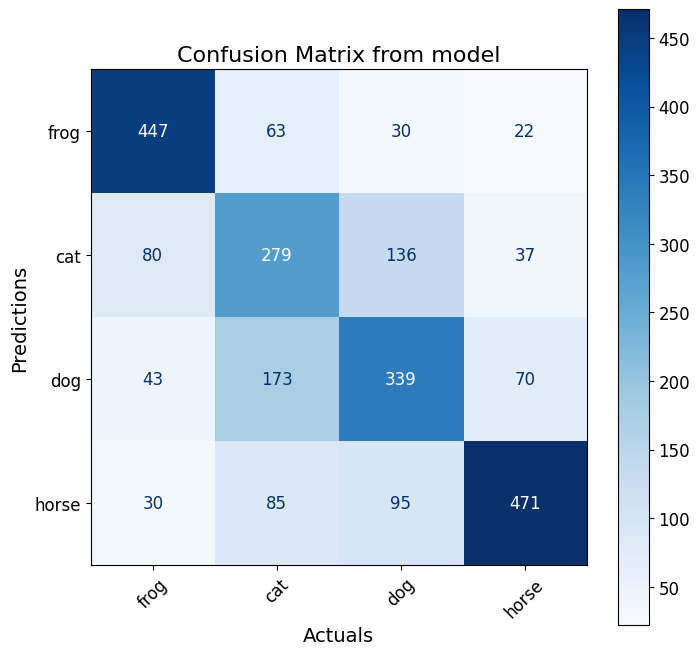

In [68]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title('Confusion Matrix from model', fontsize=16)
plt.show()

In [69]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

        frog       0.80      0.74      0.77       600
         cat       0.52      0.47      0.49       600
         dog       0.54      0.56      0.55       600
       horse       0.69      0.79      0.74       600

    accuracy                           0.64      2400
   macro avg       0.64      0.64      0.64      2400
weighted avg       0.64      0.64      0.64      2400



In [70]:
print("ศิริสุข ทานธรรม 6610402230")

ศิริสุข ทานธรรม 6610402230
